# Windowed prediction

This notebook is simply to reproduce how a single prediction is done.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from functools import reduce
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter1d
from tqdm import tqdm
from typing import List

sys.path.append("/Users/renero/Documents/SideProjects/trader/src")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/predictor")


from dictionary import Dictionary
from lstm import lstm
from predictor.ticks import Ticks
from predictor.sequences import sequences
from utils.utils import print_bin_predictions_match
from utils.plot_utils import plot_marks


%load_ext lab_black
%matplotlib inline

In [2]:
argv = [
    "",
    "-c",
    "../params/params.eurusd.yaml",
    "-f",
    "../data/EURUSD/EURUSD_2018_2020.csv",
    "--window",
    "28",
    "--epochs",
    "100",
    "train",
]
params = Dictionary(args=argv)


def read_ticks():
    global params

    ticks = Ticks(params, params.input_file).scale()
    ticks.append_indicator(["trend", "median_filter", "change"])
    ticks.append_indicator("gmf", monotonic_window=7, mf_window=3, sigma=5)
    ticks.append_indicator("gmf_mono", monotonic_window=7, mf_window=3, sigma=5)
    ticks.append_indicator("trend", column_name="gmf")
    return ticks


ticks = read_ticks()
XT, yT, Xt, yt = ticks.prepare_for_training(
    predict_column="close_trend", train_columns=["gmf", "gmf_mono", "gmf_trend"]
)
ticks.data.head()

TypeError: __init__() got an unexpected keyword argument 'args'

---

## Compruebo si matchean la serie temporal y la serie numerica

Primero saco cual es la fecha del ultimo evento en training. Con el puedo construir una ventana de eventos con igual numero a la izqda y a la decha, que sea el numero de eventos de test.

In [ ]:
last_date_in_training = ticks.last_date_in_training()
n_ticks = ticks.data.shape[0]
n_test = ticks.data.loc[ticks.data.index > last_date_in_training].shape[0]
D_size = int(np.ceil(2 * n_test))
print(f"{D_size} ticks, {n_test} in test and {D_size-n_test} in train (blue)")
D = ticks.data.iloc[-D_size:]

In [ ]:
plt.figure(figsize=(18, 8))
plt.axvline(pd.Timestamp(last_date_in_training), alpha=0.2, color="k", linestyle="--")
plt.plot(D.loc[D.index <= last_date_in_training].close, marker=".")
plt.plot(D.loc[D.index > last_date_in_training].close, marker=".")
plt.plot(D.close + 0.2, color="grey", alpha=0.4, marker=".")
plt.show()

Ahora saco una ventana equivalente, pero utilizando la serie numérica, SIN fechas. Para ello utilizo el método privado `_last_index_in_training()` que me da el indice del último evento del conjunto de entrenamiento. Añadiendole `1`, lo que consigo es el primer valor en test (fit = first index in test) que me sirve para recrear la ventana de arriba, pero SIN fechas.

In [ ]:
fit = (
    sequences._last_index_in_training(ticks.data, params.window_size, params.test_size)
    + 1
)
lit = fit - 1
n_test = n_ticks - fit
origin = n_ticks - (2 * n_test)
print(
    f"{n_ticks-origin} ticks, {n_test} in test and {n_ticks-origin-n_test} in training"
)

In [ ]:
plt.figure(figsize=(18, 8))
plt.plot(
    range(origin, n_ticks),
    ticks.data.close.values[origin:] + 0.2,
    color="grey",
    alpha=0.4,
    marker=".",
)
plt.axvline(fit - 1, alpha=0.2, color="k", linestyle="--")
plt.plot(range(origin, lit + 1), ticks.data.close.values[origin : lit + 1], marker=".")
plt.plot(range(fit, n_ticks), ticks.data.close.values[fit:n_ticks], marker=".")
plt.show()

---

# Predicciones con redes guardadas

### 1) Leo las redes de disco.

In [ ]:
scaler_file = "../staging/EURUSD/scaler_EURUSD_2018_2020.bin"
nn1: List[lstm] = []
nn2: List[lstm] = []
nn3: List[lstm] = []
close_trend_models = [
    "LSTMb_close_trend;1L;u28;d0.20;lr0.01;W14;E150;BS8",
    "LSTMb_close_trend;1L;u28;d0.20;lr0.01;W28;E150;BS8",
    "LSTMb_close_trend;1L;u42;d0.10;lr0.01;W28;E150;BS16",
]
gmf_trend_models = [
    "LSTMb_gmf_trend;1L;u28;d0.20;lr0.01;W14;E150;BS8",
    "LSTMb_gmf_trend;1L;u28;d0.20;lr0.01;W28;E150;BS8",
    "LSTMb_gmf_trend;1L;u42;d0.20;lr0.01;W28;E150;BS16",
]
gmf_mono_models = [
    "LSTM_gmf_mono;1L;u28;d0.20;lr0.01;W14;E150;BS8",
    "LSTM_gmf_mono;1L;u28;d0.20;lr0.01;W28;E150;BS8",
    "LSTM_gmf_mono;1L;u42;d0.10;lr0.01;W28;E150;BS16",
]
[nn1.append(lstm(params).load(network)) for network in close_trend_models]
[nn2.append(lstm(params).load(network)) for network in gmf_trend_models]
[nn3.append(lstm(params).load(network)) for network in gmf_mono_models]

### 2) Leo los datos y me quedo solo con los datos de test.

In [ ]:
raw = Ticks(params, csv_file=params.input_file).scale(scaler_file)
raw.append_indicator(["trend", "median_filter", "change"])
raw.append_indicator("gmf", monotonic_window=7, mf_window=3, sigma=5)
raw.append_indicator("gmf_mono", monotonic_window=7, mf_window=3, sigma=5)
raw.append_indicator("trend", column_name="gmf")

n_windows = 0
last_training_date = raw.last_date_in_training()
test_df = raw.data.loc[raw.data.index > last_training_date]
train_df = raw.data.loc[raw.data.index <= last_training_date]

### 3) Creo un objeto Ticks, con los indicadores

In [ ]:
test = Ticks(params, df=test_df)
train = Ticks(params, df=train_df)
test.data.head()

---
## Predicciones GMF_close
---

In [ ]:
def combine_predictions(predictions, threshold=0.5):
    sum = 0
    for pred in predictions:
        if pred >= threshold:
            sum += 1
    return int(sum >= int(np.ceil(len(predictions) / 2.0)))


def combine_multinomial_predictions(predictions, threshold=0.5):
    return np.argmax(reduce(np.add, predictions))


def return_ensembled_predictions(dataset, train_columns, networks):
    prepared_data = dataset.prepare_for_predict(train_columns)
    yhat = []
    for input_to_net in tqdm(prepared_data):
        input_to_net = input_to_net.reshape(1, -1, len(train_columns))
        all_predictions = [network.model.predict(input_to_net) for network in networks]
        if networks[0].metadata["binary"]:
            yhat.append(combine_predictions(all_predictions))
        else:
            yhat.append(combine_multinomial_predictions(all_predictions))
    return yhat

In [ ]:
yhat1 = return_ensembled_predictions(test, ["gmf", "gmf_mono", "gmf_trend"], nn1)
y1 = test.data.iloc[-84:].close_trend.values.astype(int)
print("Accuracy:", accuracy_score(y1, yhat1))

---
# Predicciones GMF_trend
---

In [ ]:
yhat2 = return_ensembled_predictions(test, ["gmf", "gmf_mono"], nn2)
y2 = test.data.iloc[-84:].gmf_trend.values.astype(int)
print("Accuracy:", accuracy_score(y2, yhat2))

---
# Predicciones GMF_MONO
---

In [ ]:
yhat3 = return_ensembled_predictions(test, ["gmf", "gmf_trend"], nn3)
y3 = test.data.iloc[-84:].gmf_mono.values.astype(int)
y3 += 1
print("Accuracy:", accuracy_score(y3, yhat3))

---

Ahora debería entrenar también tres redes que predigan la señal gmf_trend, combinarlas y con esas dos intentar calcular la marca de BUY/SELL/HOLD.

In [ ]:
def f(A, B, a, b, X):
    """Projects X values from interval [A, B] into new interval [a, b]"""
    return [(val - A) * (b - a) / (B - A) + a for val in X]


plt.figure(figsize=(14, 8))
plt.plot(
    test.data.iloc[-84:].close.values,
    color="green",
    alpha=0.8,
    label="close",
    linewidth=0.5,
)
plt.plot(test.data.iloc[-84:].gmf.values * 10.0, color="grey", alpha=0.8, label="gmf")
# plt.scatter(
#    range(len(y1)),
#    test.data.iloc[-84:].gmf_trend,
#    alpha=0.5,
#    marker=".",
#    label="gmf_trend",
# )
# plt.scatter(
#    range(len(y1)),
#    test.data.iloc[-84:].close_trend,
#    alpha=0.5,
#    marker="+",
#    label="close_trend",
# )
# plt.scatter(
#    range(len(y1)),
#    np.array(f(-1, 1, -0.15, 0.15, test.data.iloc[-84:].gmf_mono)),
#    alpha=0.5,
#    marker="|",
#    label="gmf_mono",
# )
plt.scatter(
    range(len(y1)),
    np.array(yhat1) + 0.05,
    alpha=0.5,
    marker="x",
    label="close_trend prediction",
)
plt.scatter(
    range(len(y1)),
    np.array(yhat2) - 0.05,
    alpha=0.5,
    marker="x",
    label="gmf_trend prediction",
)
plt.scatter(
    range(len(y1)),
    np.array(f(0, 2, -0.2, 0.2, yhat3)),
    alpha=0.5,
    marker="x",
    label="gmf_mono prediction",
)
plt.legend()
plt.tight_layout()
plt.savefig("averaver.png")
plt.show()

# Combine $yhat_1$ and $yhat_2$ 

In [2]:
del params["args"]
print(params)

NameError: name 'params' is not defined

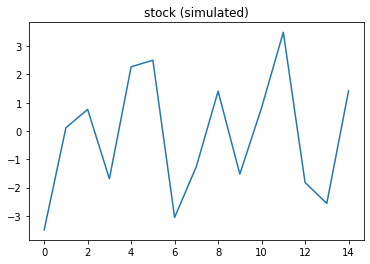

In [15]:
def f(x):
    return -np.cos(x) - np.sin(x) - (5 / 2) * np.cos(2 * x) + (1 / 2) * np.sin(2 * x)


X = np.arange(15.0)
s = pd.DataFrame({"x1": X, "x2": [f(x) for x in X]})

plt.plot(s.x2)
plt.title("stock (simulated)")
plt.show()

Plotting the MF with the data available ONLY up to a certain day (starting at 8th day, up to 13th), the result is that MF with partial data doesn't match the MF computed over the entire series of data, but deviates not too much. In a real life scenario, this shorter window can be extended with the forecast value of the signal for the next day to get a more accurate approximation of the MF signal.

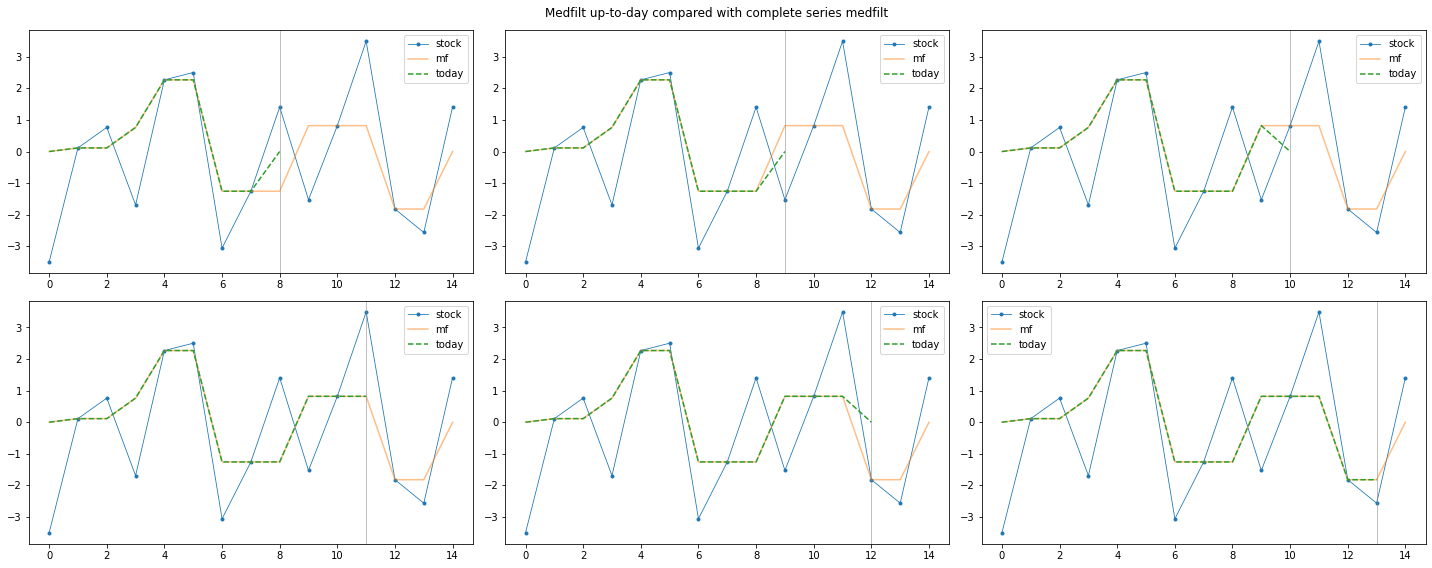

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(20, 8)
w_size = 9
for row in range(2):
    for column in range(3):
        ax[row, column].plot(s.x2, linewidth=0.8, marker=".", label="stock")
        ax[row, column].plot(medfilt(s.x2, kernel_size=3), alpha=0.5, label="mf")
        ax[row, column].plot(
            medfilt(s.x2[:w_size], kernel_size=3), linestyle="dashed", label="today"
        )
        ax[row, column].axvline(w_size - 1, linewidth=0.5, color="grey")
        ax[row, column].legend()
        w_size += 1

fig.suptitle("Medfilt up-to-day compared with complete series medfilt")
plt.tight_layout()
plt.show()

Gaussian filtered signal computed over the stretched up-to-day window suffers the same deviation, as it is computed over the shorter MF signal. By using forecast we could get a more accurate version of the Gaussian1d filter, given that the forecast is correct.

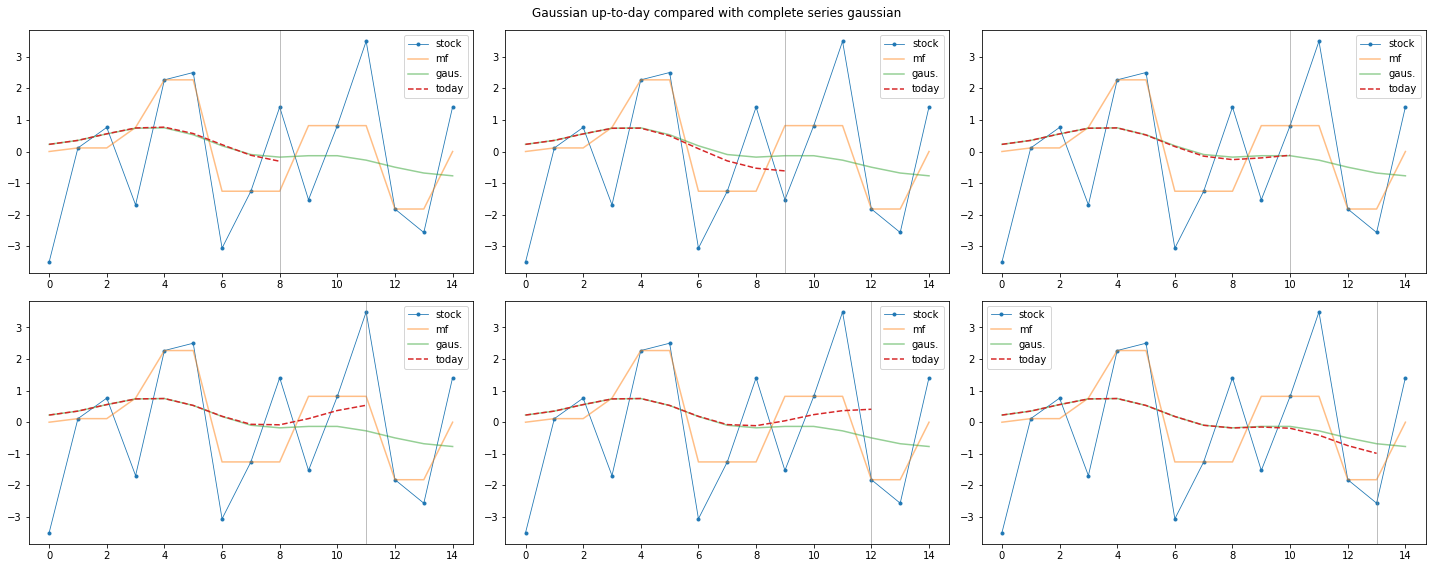

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(20, 8)
w_size = 9
for row in range(2):
    for column in range(3):
        ax[row, column].plot(s.x2, linewidth=0.8, marker=".", label="stock")
        ax[row, column].plot(
            medfilt(s.x2, kernel_size=3), alpha=0.5, label="mf",
        )
        ax[row, column].plot(
            gaussian_filter1d(medfilt(s.x2, kernel_size=3), sigma=2),
            alpha=0.5,
            label="gaus.",
        )
        ax[row, column].plot(
            gaussian_filter1d(medfilt(s.x2[:w_size], kernel_size=3), sigma=2),
            linestyle="dashed",
            label="today",
        )
        ax[row, column].axvline(w_size - 1, linewidth=0.5, color="grey")
        w_size += 1
        ax[row, column].legend()

fig.suptitle("Gaussian up-to-day compared with complete series gaussian")
plt.tight_layout()
plt.show()